# TIME SERIE FORECAST WITH PROPHET

## The data contains the daily minimum temperatures in Melbourne (AU) over a period of 10 years.

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import STL
from prophet import Prophet
import prophet.plot as plot

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(15, 6)})
sns.set(font_scale=1) 

In [2]:
df_raw=pd.read_excel("daily-min-temp-me.xlsx")
df=df_raw.copy()
df.head(10)

,Date,Daily minimum temperatures
0,1981-01-01 00:00:00,20.7
1,1981-01-02 00:00:00,15.3
2,1981-01-03 00:00:00,17.8
3,1981-01-04 00:00:00,16.7
4,1981-01-05 00:00:00,8.6
5,1981-01-06 00:00:00,11.6
6,1981-01-07 00:00:00,10.7
7,1981-01-08 00:00:00,5.7
8,1981-01-09 00:00:00,8.0
9,1981-01-10 00:00:00,8.9


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        3650 non-null   object 
 1   Daily minimum temperatures  3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


## CHECK

In [4]:
# RENAME COLUMNS
df.columns=["date","temp"]

# CONVERT DATE COLUMN IN PANDAS DATETIME
df["date"]=pd.to_datetime(df["date"])

In [5]:
df.columns

Index(['date', 'temp'], dtype='object')

In [6]:
df=df.sort_values(by="date")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3650 entries, 0 to 2187
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3650 non-null   datetime64[ns]
 1   temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 85.5 KB


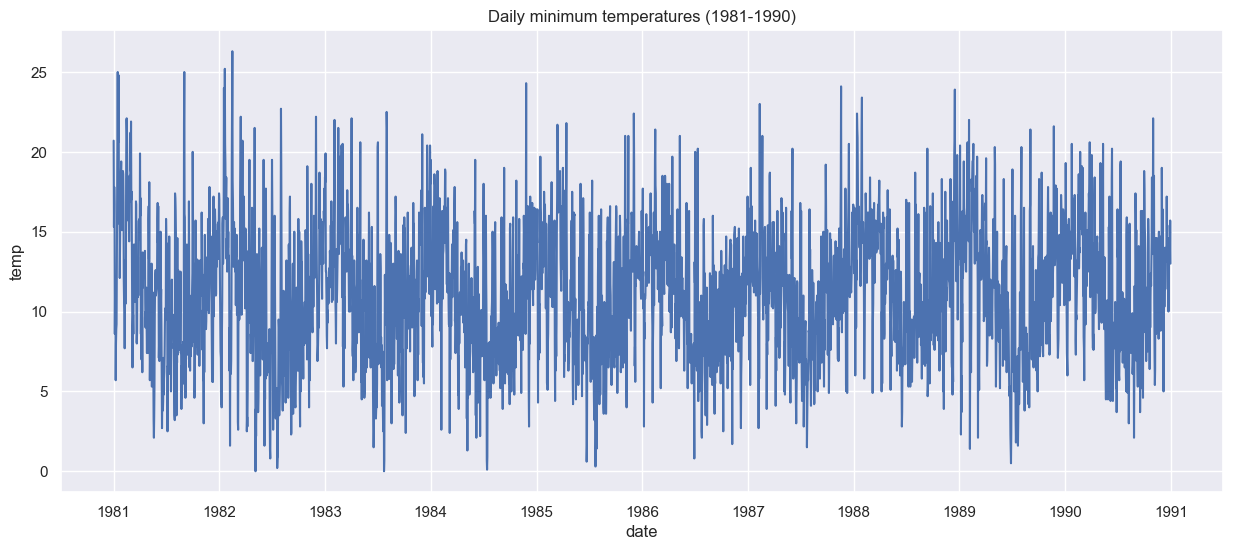

In [8]:
graph=sns.lineplot(x='date', y='temp', data=df)
graph.set_title("Daily minimum temperatures (1981-1990)")
plt.show()

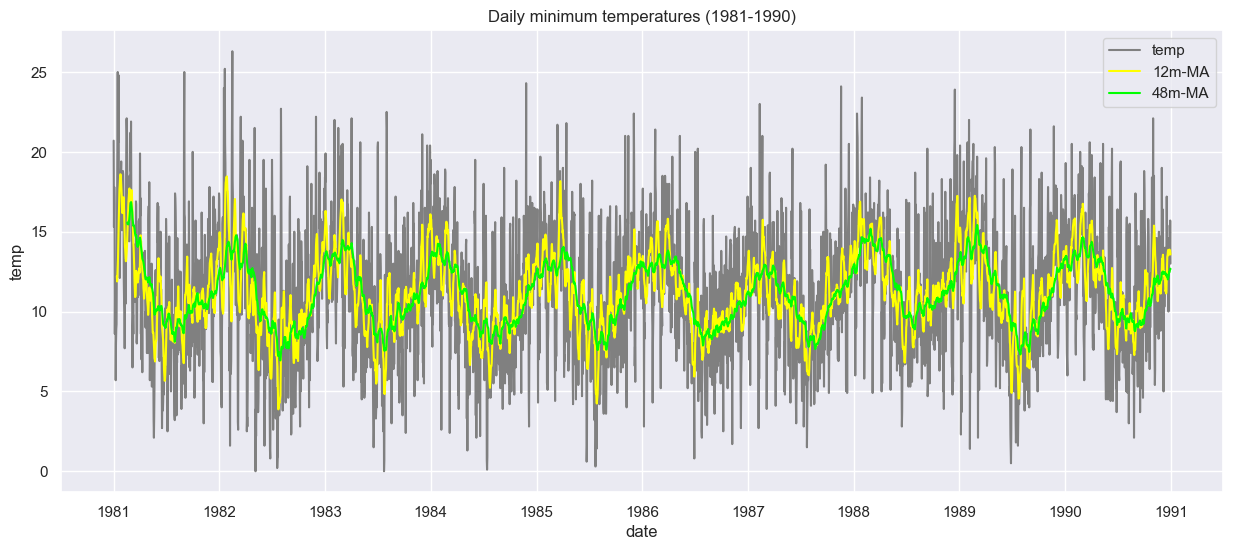

In [9]:
# MOVING AVG (time-lag of 12 and 48 months)
df['ma12'] = df['temp'].rolling(window=12).mean()
df['ma48'] = df['temp'].rolling(window=48).mean()

# PLOT MOVING AVG
graph = sns.lineplot(x='date', y='temp', data=df, label='temp', color='grey')
graph = sns.lineplot(x='date', y='ma12', data=df, label='12m-MA', color='yellow')
graph = sns.lineplot(x='date', y='ma48', data=df, label='48m-MA', color='lime')
graph.set_title('Daily minimum temperatures (1981-1990)')
plt.show()

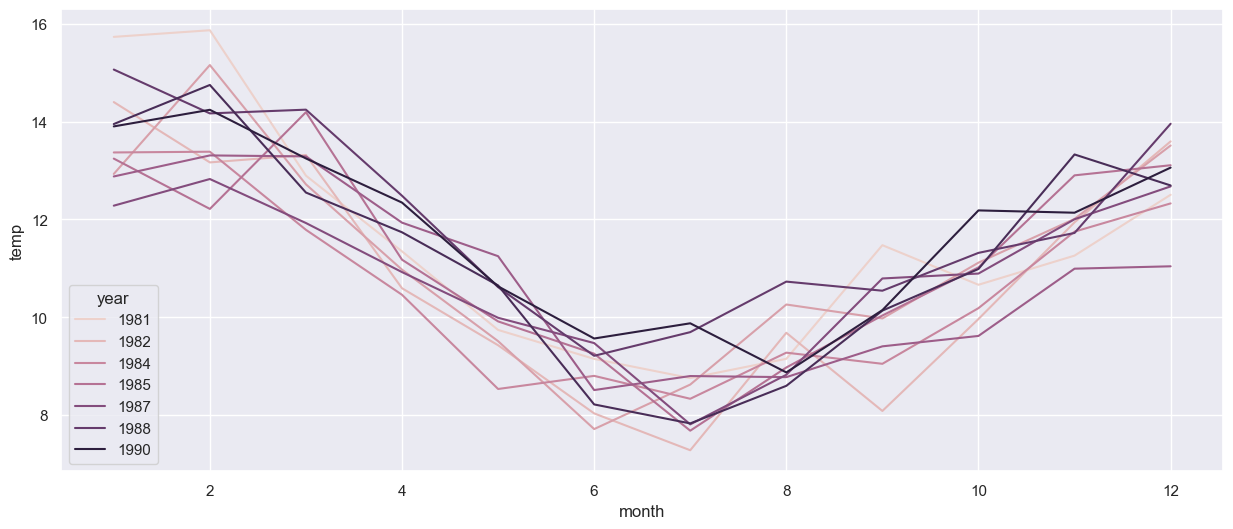

In [10]:
# MONTHLY TREND ALL YEARS
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

sns.lineplot(x='month', y='temp', hue='year', data=df.groupby(['year', 'month'], as_index=False)['temp'].mean())
plt.show()

## DECOMPOSITION

In [11]:
temp_s = pd.Series(df['temp'].values, index=df['date'])

In [12]:
temp_s.head()

date
1981-01-01    20.7
1981-01-02    15.3
1981-01-03    17.8
1981-01-04    16.7
1981-01-05     8.6
dtype: float64

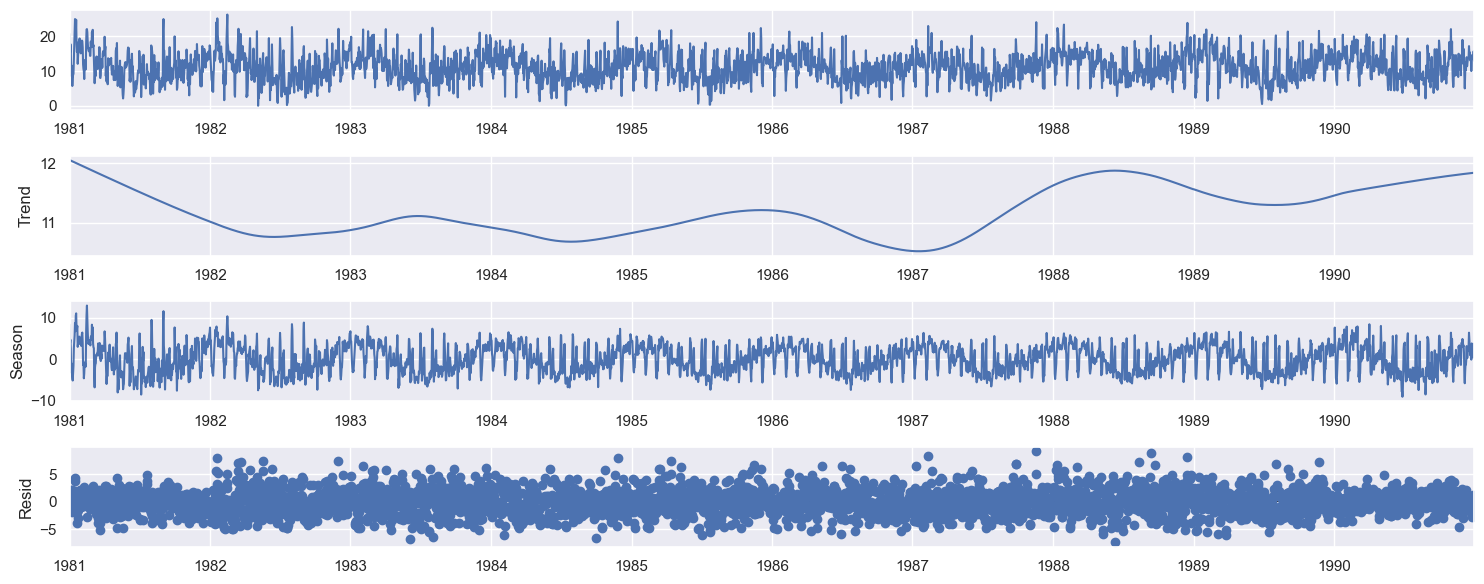

In [13]:
res = STL(temp_s, period=365).fit()
res.plot()
plt.show()


## MODEL WITH PROPHET

In [14]:
df_p = df[['date', 'temp']].copy()
df_p.columns = ['ds', 'y'] # RENAME COLUMN FOR PROPHET

# TRAIN AND TEST
train = df_p[df_p['ds']<'1990-01-01']
test = df_p[df_p['ds']>='1990-01-01']

In [15]:
# FIT THE MODEL
m = Prophet()
m.fit(train)

# EXTEND DATES FOR FUTURE PREDICTIONS
future = m.make_future_dataframe(periods=365)
#future.tail()

# COMPUTE PREDICTIONS
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

15:27:42 - cmdstanpy - INFO - Chain [1] start processing
15:27:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
3645,1990-12-27,13.822277,9.446047,18.347469
3646,1990-12-28,14.028571,9.438101,18.479967
3647,1990-12-29,14.060194,9.614818,18.895452
3648,1990-12-30,14.114126,9.315934,18.578471
3649,1990-12-31,14.199167,9.172599,18.470507


In [16]:
# plot data, forecasts 
plot.plot_plotly(m, forecast)

In [17]:
# plot components
plot.plot_components_plotly(m, forecast)

# EVALUATE THE MODEL

In [18]:
# measure model's performance/accuracy
pred_err = test.merge(forecast[forecast['ds']>='1990-01-01'][['ds','yhat']])
pred_err['pred_error'] = pred_err.y - pred_err.yhat
#pred_err

# MAE: 
mae = np.mean(np.abs(pred_err.pred_error))
print(f'MAE: {round(mae,2)}')
# MAPE
mape = np.mean(np.abs(pred_err.pred_error/pred_err.y))*100
print(f'MAPE: {round(mape,2)}%')

MAE: 2.69
MAPE: 28.5%
